In [1]:
import tensorflow as tf
import utils as u
import h5py
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import os
import numpy as np
import random as rn


from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn import metrics

%matplotlib inline
import itertools

import keras 
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten,Conv2D, MaxPooling2D,Activation,BatchNormalization,LeakyReLU
from keras.utils import to_categorical,plot_model
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
#for reproducibility in Python,numpy and Tensorflow we set their respective seeds as follows
os.environ['PYTHONHASHSEED']='0'
np.random.seed(None) ##don't want to seed numpy with random sized hot/dead regions
rn.seed(2)
tf.set_random_seed(3)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

#Force Tensorflow to use a single thread (this is recommended because it might be a cause of randomness)
sess=tf.Session(graph=tf.get_default_graph(),config=session_conf)
K.set_session(sess)

In [3]:
data_folder = '../../data'
file_name = 'HCAL_digi+rechit_occ.hdf5'
group = 'DigiTask_Occupancy_depth_depth1'

runs = ['306459','306138','306138']

data_sample= np.empty([0,72,84])
for run in runs:
    input_file=h5py.File(data_folder+'/'+'HCAL_digi+rechit_occ_run'+run+'.hdf5','r+')
    data_sample = np.concatenate((data_sample,np.array(input_file[group])),axis=0)
    
print data_sample.shape

data_sample=data_sample[:,:,26:58]

print data_sample.shape

(2997, 72, 84)
(2997, 72, 32)


Shape of regular image is:  (2997, 72, 32)
Shape of dead image is:  (1479, 72, 32)
Shape of hot image is:  (1518, 72, 32)



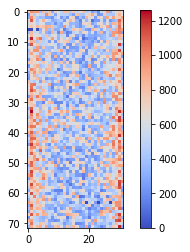

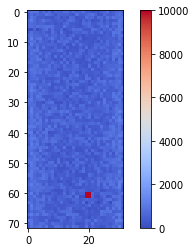

In [4]:
input_images=data_sample[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    
    yn = np.random.randint(2)
    
    xLen = np.random.randint(1,17)
    yLen = np.random.randint(1,17)
    
    a=np.random.randint(input_images.shape[2]-xLen)
    b=np.random.randint(input_images.shape[1]-yLen)
    
    xdim=(a,a+xLen)
    ydim=(b,b+yLen)
    
    #print 'xdim =', xdim
    #print 'ydim =', ydim
    
    if yn == 1:
        hotregion_image.append( u.hotregion(k,xdim,ydim))
    else:
        deadregion_image.append(u.killregion(k,xdim,ydim))
       
    
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape

print ''
im=plt.imshow(input_images[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()


im=plt.imshow(hotregion_image[1],cmap=cm.coolwarm)
plt.colorbar()
plt.show()
plt.clf()#plt.clf clears the figure and it's axis but leaves the window open. 
         #as opposed to plt.close which closes the window. If you are showing many images at a time without
         #closing the window it is better.

#input_image=np.reshape(input_image,(input_image.shape[0],input_image.shape[1]))


In [5]:
sample= np.append(data_sample,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
print sample.shape

(5994, 72, 32)


In [6]:
X=np.copy(sample)

y=np.zeros((sample.shape[0],1))
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1
#print y.shape
#print input_images.shape[0]


#this is because I am only going to add the hot and dead region images

### Changed this to a 2 class problem, good and bad
y[-1*input_images.shape[0]:]=1
#if you want it as integers leave this as it is
#if you would like it as a vector then do this

y=to_categorical(y,2)

# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
img_rows, img_cols = X.shape[1],X.shape[2]

X shape is:  (5994, 72, 32)
y shape is:  (5994, 2)


Xtrain.shape (3596, 72, 32)
Xtest.shape (2398, 72, 32)
ytrain.shape (3596, 2)
ytest.shape (2398, 2)
Printing labels and their corresponding images
-------------------
[ 0.  1.]


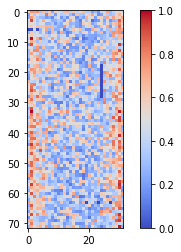

-------------------
[ 0.  1.]


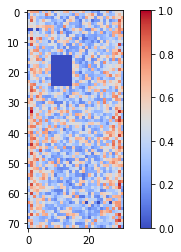

-------------------
[ 0.  1.]


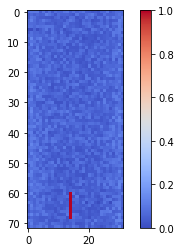

-------------------
[ 0.  1.]


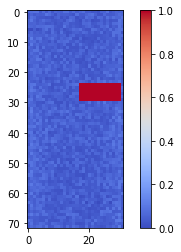

-------------------
[ 0.  1.]


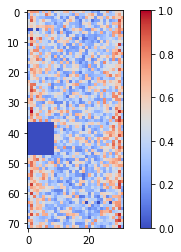

-------------------
[ 1.  0.]


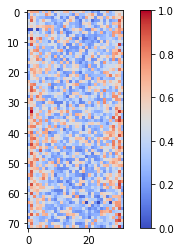

-------------------
[ 0.  1.]


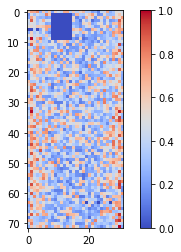

-------------------
[ 1.  0.]


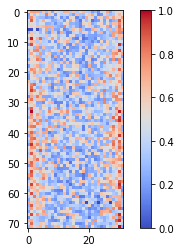

-------------------
[ 0.  1.]


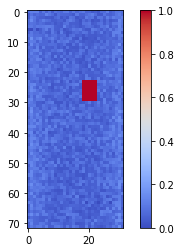

-------------------
[ 0.  1.]


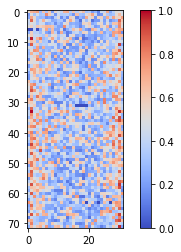

Xtrain.shape after if statement (3596, 72, 32, 1)
Xtest.shape after if statement (2398, 72, 32, 1)
ytrain.shape after if statement (3596, 2)
ytest.shape after if statement (2398, 2)


In [7]:
Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=.4,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape
print 'Printing labels and their corresponding images'
    
for k in range(10):
    print'-------------------'
    print ytrain[k]
    im=plt.imshow(Xtrain[k],cmap=cm.coolwarm)
    plt.colorbar()
    plt.show()
    plt.clf()


Xtrain, Xtest,input_shape= u.check_test_and_train_images_format(Xtrain, Xtest, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    

In [8]:
"""A Custom Loss Function"""

#### [0.1,0.9] works well (acc > 0.99) but still no movement across the diagonal

x = np.array([[0.1,0.9]])
w = K.variable(x, name='w')

def customLoss(yTrue,yPred):
    return K.sum(K.dot(w, K.transpose(K.square(yTrue - yPred))))

In [9]:
"""this is the dummy model"""
#model = Sequential()

#model.add(Conv2D(10, kernel_size=(2, 2), strides=(1, 1),input_shape=input_shape))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Conv2D(8, kernel_size=(3, 3),strides=(1, 1)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2,2)))

#model.add(Conv2D(8,kernel_size=(1,1)))
#model.add(BatchNormalization())
#model.add(Activation('relu'))
#
#model.add(Dropout(0.25))
#model.add(Flatten())

#model.add(Dense(8))
#model.add(BatchNormalization())
#model.add(Activation('relu'))

##Last layer is Dense (as usual), note output size (first arg) is label size
#model.add(Dense(2, activation='softmax'))


#model.compile(loss='categorical_crossentropy',
#              optimizer='Nadam',#Adam(lr=1e-3),
#              metrics=['accuracy'])
#model.summary()
#plot_model(model, to_file='Supervised_model.png',)
#
#model.save('emptymodel.hdf5')

"""This is a more minimal model"""

model = Sequential()

model.add(Conv2D(5, kernel_size=(3, 3), strides=(1, 1),input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Dropout(0.25))
model.add(Flatten())

#Last layer is Dense (as usual), note output size (first arg) is label size
model.add(Dense(2, activation='softmax'))


model.compile(loss=customLoss,
              optimizer='Nadam',#Adam(lr=1e-3),
              metrics=['accuracy'])

model.summary()
plot_model(model, to_file='Supervised_model.png',)

model.save('emptymodel.hdf5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 70, 30, 5)         50        
_________________________________________________________________
batch_normalization_1 (Batch (None, 70, 30, 5)         20        
_________________________________________________________________
activation_1 (Activation)    (None, 70, 30, 5)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 10, 5)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 10, 5)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1150)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2302      
Total para

In [10]:
checkpointer = ModelCheckpoint(filepath='best_nbmodel_good_bad.hdf5', verbose=2, save_best_only=True)
earlystop= EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='auto')

In [11]:
history = model.fit(Xtrain,ytrain,epochs=300
                    ,verbose=2
                    ,validation_data=(Xtest,ytest)
                    ,shuffle=True
                    ,callbacks=[checkpointer,earlystop])

Train on 3596 samples, validate on 2398 samples
Epoch 1/300
Epoch 00001: val_loss improved from inf to 9.81362, saving model to best_nbmodel_good_bad.hdf5
 - 23s - loss: 9.3382 - acc: 0.6549 - val_loss: 9.8136 - val_acc: 0.4887
Epoch 2/300
Epoch 00002: val_loss improved from 9.81362 to 7.36783, saving model to best_nbmodel_good_bad.hdf5
 - 22s - loss: 8.5860 - acc: 0.7125 - val_loss: 7.3678 - val_acc: 0.7456
Epoch 3/300
Epoch 00003: val_loss did not improve
 - 22s - loss: 8.2488 - acc: 0.7380 - val_loss: 7.8038 - val_acc: 0.7465
Epoch 4/300
Epoch 00004: val_loss did not improve
 - 23s - loss: 8.8701 - acc: 0.7152 - val_loss: 8.3092 - val_acc: 0.7431
Epoch 5/300
Epoch 00005: val_loss did not improve
 - 22s - loss: 8.0500 - acc: 0.7486 - val_loss: 8.1498 - val_acc: 0.7481
Epoch 6/300
Epoch 00006: val_loss did not improve
 - 22s - loss: 8.0171 - acc: 0.7475 - val_loss: 8.0843 - val_acc: 0.7490
Epoch 7/300
Epoch 00007: val_loss did not improve
 - 23s - loss: 8.0004 - acc: 0.7436 - val_loss

Epoch 55/300
Epoch 00055: val_loss did not improve
 - 23s - loss: 1.1727 - acc: 0.9552 - val_loss: 1.3991 - val_acc: 0.9420
Epoch 56/300
Epoch 00056: val_loss did not improve
 - 23s - loss: 1.2344 - acc: 0.9533 - val_loss: 1.0762 - val_acc: 0.9600
Epoch 57/300
Epoch 00057: val_loss did not improve
 - 24s - loss: 1.0395 - acc: 0.9627 - val_loss: 0.8740 - val_acc: 0.9650
Epoch 58/300
Epoch 00058: val_loss did not improve
 - 23s - loss: 0.9216 - acc: 0.9664 - val_loss: 0.8281 - val_acc: 0.9666
Epoch 59/300
Epoch 00059: val_loss did not improve
 - 24s - loss: 0.9899 - acc: 0.9638 - val_loss: 0.9598 - val_acc: 0.9658
Epoch 60/300
Epoch 00060: val_loss did not improve
 - 22s - loss: 1.0611 - acc: 0.9611 - val_loss: 1.0127 - val_acc: 0.9616
Epoch 61/300
Epoch 00061: val_loss did not improve
 - 23s - loss: 0.9158 - acc: 0.9658 - val_loss: 1.0468 - val_acc: 0.9554
Epoch 62/300
Epoch 00062: val_loss did not improve
 - 23s - loss: 1.2193 - acc: 0.9561 - val_loss: 0.9393 - val_acc: 0.9633
Epoch 63

Epoch 115/300
Epoch 00115: val_loss did not improve
 - 23s - loss: 0.4891 - acc: 0.9828 - val_loss: 0.4690 - val_acc: 0.9846
Epoch 116/300
Epoch 00116: val_loss did not improve
 - 22s - loss: 0.4982 - acc: 0.9816 - val_loss: 0.4273 - val_acc: 0.9862
Epoch 117/300
Epoch 00117: val_loss did not improve
 - 23s - loss: 0.4476 - acc: 0.9839 - val_loss: 0.7672 - val_acc: 0.9892
Epoch 118/300
Epoch 00118: val_loss did not improve
 - 23s - loss: 0.4978 - acc: 0.9808 - val_loss: 0.5178 - val_acc: 0.9800
Epoch 119/300
Epoch 00119: val_loss improved from 0.40773 to 0.40426, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 0.4656 - acc: 0.9839 - val_loss: 0.4043 - val_acc: 0.9875
Epoch 120/300
Epoch 00120: val_loss did not improve
 - 24s - loss: 0.4179 - acc: 0.9847 - val_loss: 0.4277 - val_acc: 0.9854
Epoch 121/300
Epoch 00121: val_loss improved from 0.40426 to 0.38974, saving model to best_nbmodel_good_bad.hdf5
 - 24s - loss: 0.3934 - acc: 0.9855 - val_loss: 0.3897 - val_acc: 0.9871
Epo

Epoch 177/300
Epoch 00177: val_loss did not improve
 - 25s - loss: 0.2037 - acc: 0.9930 - val_loss: 0.3356 - val_acc: 0.9871
Epoch 178/300
Epoch 00178: val_loss did not improve
 - 23s - loss: 0.3456 - acc: 0.9886 - val_loss: 0.4200 - val_acc: 0.9846
Epoch 179/300
Epoch 00179: val_loss did not improve
 - 24s - loss: 0.3456 - acc: 0.9883 - val_loss: 0.3660 - val_acc: 0.9867
Epoch 180/300
Epoch 00180: val_loss did not improve
 - 24s - loss: 0.2943 - acc: 0.9903 - val_loss: 0.3260 - val_acc: 0.9871
Epoch 181/300
Epoch 00181: val_loss did not improve
 - 24s - loss: 0.2276 - acc: 0.9925 - val_loss: 0.2970 - val_acc: 0.9879
Epoch 182/300
Epoch 00182: val_loss improved from 0.28047 to 0.27430, saving model to best_nbmodel_good_bad.hdf5
 - 26s - loss: 0.2635 - acc: 0.9911 - val_loss: 0.2743 - val_acc: 0.9921
Epoch 183/300
Epoch 00183: val_loss improved from 0.27430 to 0.27347, saving model to best_nbmodel_good_bad.hdf5
 - 25s - loss: 0.2010 - acc: 0.9936 - val_loss: 0.2735 - val_acc: 0.9887
Epo

Epoch 240/300
Epoch 00240: val_loss did not improve
 - 23s - loss: 0.2190 - acc: 0.9925 - val_loss: 0.2577 - val_acc: 0.9904
Epoch 241/300
Epoch 00241: val_loss did not improve
 - 23s - loss: 0.1864 - acc: 0.9939 - val_loss: 0.2392 - val_acc: 0.9912
Epoch 242/300
Epoch 00242: val_loss did not improve
 - 25s - loss: 0.1620 - acc: 0.9947 - val_loss: 0.2324 - val_acc: 0.9912
Epoch 243/300
Epoch 00243: val_loss did not improve
 - 24s - loss: 0.1442 - acc: 0.9950 - val_loss: 0.2838 - val_acc: 0.9887
Epoch 244/300
Epoch 00244: val_loss improved from 0.23061 to 0.22876, saving model to best_nbmodel_good_bad.hdf5
 - 23s - loss: 0.1332 - acc: 0.9961 - val_loss: 0.2288 - val_acc: 0.9917
Epoch 245/300
Epoch 00245: val_loss did not improve
 - 24s - loss: 0.1876 - acc: 0.9936 - val_loss: 0.2456 - val_acc: 0.9904
Epoch 246/300
Epoch 00246: val_loss did not improve
 - 26s - loss: 0.1597 - acc: 0.9950 - val_loss: 0.2512 - val_acc: 0.9900
Epoch 247/300
Epoch 00247: val_loss did not improve
 - 25s - los

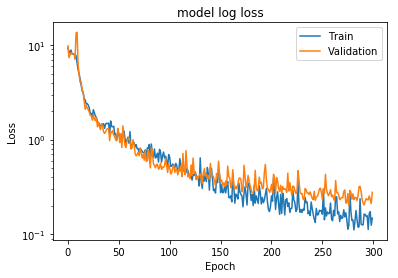

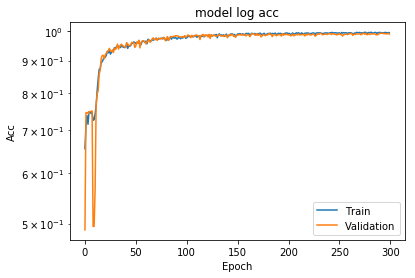

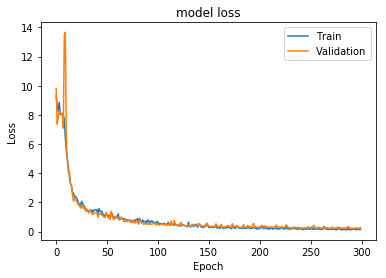

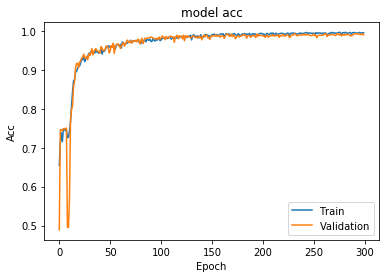

In [12]:
u.plot_loss(history, "model log loss","log")
u.plot_acc(history, "model log acc","log")

u.plot_loss(history, "model loss","linear")
u.plot_acc(history, "model acc","linear")

In [13]:
best_model= load_model('best_nbmodel_good_bad.hdf5',compile=False)

In [14]:
ypred=best_model.predict(Xtest)
ypredproba=best_model.predict_proba(Xtest)
#it's preferable to use .predict_classes because .predict might give probabilities 
#and not the label's in the case of multiclass
ypredclass=best_model.predict_classes(Xtest)

ypredclass=np.reshape(ypredclass,(ypredclass.shape[0],1))
#use argmax(1) to give the position of max value in a categorical variable like ytest
#it's basically a .predict_classes for ytest
ytestclass= ytest.argmax(1)
ytestclass=np.reshape(ytestclass,(ytestclass.shape[0],1))

Confusion matrix, without normalization
[[1211    0]
 [  18 1169]]
accuracy score:  0.992493744787


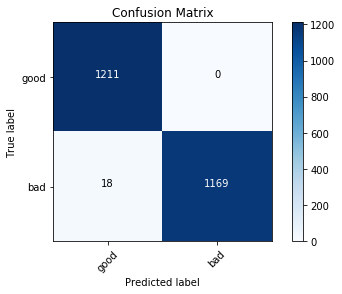

In [15]:
# from categorial to lable indexing


#yprednotcategorical =ypred.argmax(1)
#print ytestnotcategorical
#print yprednotcategorical
confusion= metrics.confusion_matrix(ytestclass,ypredclass)

plotlabels=['good','bad']
u.plot_confusion_matrix(confusion,plotlabels,title='Confusion Matrix')
print 'accuracy score: ',metrics.accuracy_score(ytestclass,ypredclass)

0.996310846168 For the label #0
0.996310846168 For the label #1


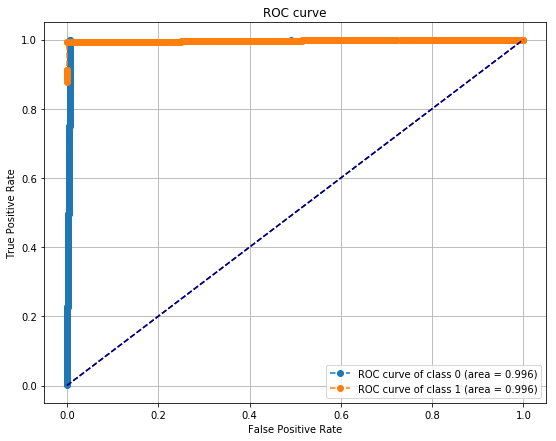

In [16]:
plt.figure(figsize=(9,7))
for i in range(ypredproba.shape[1]):
    fpr,tpr,thresholds= roc_curve(ytestclass,ypredproba[:,i],pos_label=i)
    roc_auc = auc(fpr, tpr)
    print roc_auc,'For the label #{0}'.format(i)

    plt.plot(fpr,tpr, linestyle='dashed'
             ,label='ROC curve of class {0} (area = {1:0.3f})' .format(i,roc_auc) ,marker='o')#% roc_auc, color='green'markerfacecolor='blue' ,markersize=4,
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--') 
    #plt.xlim([-.1,1.5])

    #plt.ylim([-0.1,1.5])    

    plt.title('ROC curve')

    plt.ylabel('True Positive Rate')

    plt.xlabel('False Positive Rate')

    plt.legend()

    plt.grid(True)
 

In [17]:
num_movies = data_sample.shape[0]-10
data_sample0 = np.empty([num_movies,10,72,32])

for i in range(num_movies):
    tempData = np.empty([10,72,32])
    for j in range(10):
        tempData[j] = data_sample[i+j,:,:]
    data_sample0[i] = tempData
    
print data_sample0.shape

input_images=data_sample0[:]
hotregion_image=[]
deadregion_image=[]

for k in input_images:
    
    yn = np.random.randint(2)
    
    xLen = np.random.randint(1,17)
    yLen = np.random.randint(1,17)
    
    a=np.random.randint(input_images.shape[3]-xLen)
    b=np.random.randint(input_images.shape[2]-yLen)

    c = np.random.randint(9)
    
    xdim=[a,a+xLen]
    ydim=[b,b+yLen]
    affrange = [c,k.shape[0]]
    
    if yn == 1:
        hot=u.hotTime(k,affrange,xdim,ydim)
        hotregion_image.append(hot)
    else:
        dead=u.deadTime(k,affrange,xdim,ydim)
        deadregion_image.append(dead)
    
print 'Done with loop'
hotregion_image=np.array(hotregion_image)
deadregion_image=np.array(deadregion_image)

print "Shape of regular image is: ",input_images.shape
print "Shape of dead image is: " ,deadregion_image.shape
print "Shape of hot image is: " ,hotregion_image.shape
#print hotregion_image[0]
print ''

sample= np.append(data_sample0,hotregion_image,axis=0)
sample= np.append(sample,deadregion_image,axis=0)
print sample.shape

X=np.copy(sample)

y=np.zeros((sample.shape[0],1))
k=0
for img in X:
    X[k] = X[k] / np.max(img)
    k=k+1
    
print input_images.shape
y[-1*input_images.shape[0]:]=1
#if you want it as integers leave this as it is
#if you would like it as a vector then do this
y=to_categorical(y,2)

print "X shape is: ",X.shape
print "y shape is: ",y.shape
# input image dimensions
movie_length, img_rows, img_cols = X.shape[1],X.shape[2],X.shape[3]

Xtrain, Xtest ,ytrain, ytest =train_test_split(X,y,test_size=0.99,random_state =5 )

print 'Xtrain.shape',Xtrain.shape
print 'Xtest.shape',Xtest.shape
print 'ytrain.shape',ytrain.shape
print 'ytest.shape',ytest.shape

Xtrain, Xtest,input_shape= u.check_test_and_train_images_format_movies(Xtrain, Xtest, movie_length, img_rows, img_cols)

print 'Xtrain.shape after if statement',Xtrain.shape
print 'Xtest.shape after if statement',Xtest.shape
print 'ytrain.shape after if statement',ytrain.shape
print 'ytest.shape after if statement',ytest.shape
    
print input_shape

(2987, 10, 72, 32)
Done with loop
Shape of regular image is:  (2987, 10, 72, 32)
Shape of dead image is:  (1457, 10, 72, 32)
Shape of hot image is:  (1530, 10, 72, 32)

(5974, 10, 72, 32)
(2987, 10, 72, 32)
X shape is:  (5974, 10, 72, 32)
y shape is:  (5974, 2)
Xtrain.shape (59, 10, 72, 32)
Xtest.shape (5915, 10, 72, 32)
ytrain.shape (59, 2)
ytest.shape (5915, 2)
Xtrain.shape after if statement (59, 10, 72, 32, 1)
Xtest.shape after if statement (5915, 10, 72, 32, 1)
ytrain.shape after if statement (59, 2)
ytest.shape after if statement (5915, 2)
(10, 72, 32, 1)


In [18]:
pgtg = 0.0
pbtb = 0.0
pgtb = 0.0
pbtg = 0.0

for i in range(Xtest.shape[0]):

    ypred = best_model.predict_classes(Xtest[i])
    if ypred[-1] == 0 and ytest[i][0] == 1:
        pgtg += 1.0
    elif ypred[-1] == 1 and ytest[i][0] == 0:
        pbtb += 1.0
    elif ypred[-1] == 0 and ytest[i][0] == 0:
        pgtb += 1.0
    elif ypred[-1] == 1 and ytest[i][0] == 1:
        pbtg += 1.0

acc = (pbtb+pgtg)/(pbtb+pgtg+pgtb+pbtg)
print 'accuracy score: ', acc
conf_mat = np.array([[pgtg,pbtg],[pgtb,pbtb]])
print 'Confusion Matrix: ', conf_mat

accuracy score:  0.990870667794
Confusion Matrix:  [[ 2938.    18.]
 [   36.  2923.]]
